In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
import gensim
import nltk
import requests
import datetime
import seaborn as sns
import math

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [2]:
UK_DF = pd.read_csv('data/UK_Watch_Time.csv')

In [3]:
UK_DF

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [4]:
UK_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [5]:
Duration_DF = UK_DF.groupby(['title','genres']).mean()
Duration_DF.reset_index(inplace=True)

In [6]:
Duration_Ac_DF= Duration_DF.sort_values('duration', ascending = False)

In [7]:
Top_10 = Duration_Ac_DF.head(10)

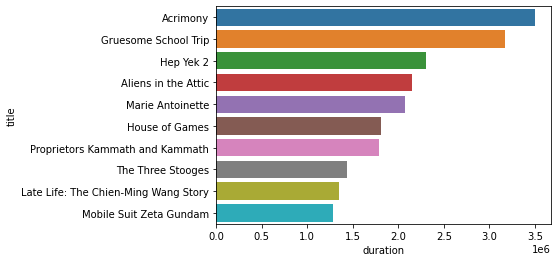

In [8]:
Duration_Top_Bar = sns.barplot(x="duration",y="title",data=Top_10)

In [9]:
Top_10.to_csv ('Top_10.csv', index = False)

In [10]:
Duration_De_DF= Duration_DF.sort_values('duration', ascending = True)

In [11]:
Duration_De_DF_NON = Duration_De_DF[(Duration_De_DF['duration']>0)]

In [12]:
Bot_10 = Duration_De_DF_NON.head(10)

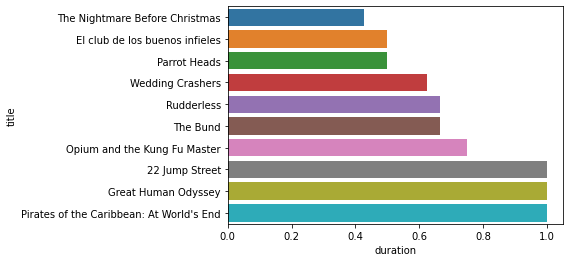

In [13]:
Duration_Bot_Bar = sns.barplot(x="duration",y="title",data=Bot_10)

In [14]:
#streaming_tvshows_df = pd.read_csv('streaming_tvshows.csv')
streaming_movies_df = pd.read_csv('data/streaming_movies.csv')

In [15]:
#streaming_tvshows_df.info()
streaming_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       9515 non-null   int64  
 1   ID               9515 non-null   int64  
 2   Title            9515 non-null   object 
 3   Year             9515 non-null   int64  
 4   Age              5338 non-null   object 
 5   IMDb             9309 non-null   object 
 6   Rotten Tomatoes  9508 non-null   object 
 7   Netflix          9515 non-null   int64  
 8   Hulu             9515 non-null   int64  
 9   Prime Video      9515 non-null   int64  
 10  Disney+          9515 non-null   int64  
 11  Type             9515 non-null   int64  
 12  Directors        9104 non-null   object 
 13  Genres           9399 non-null   object 
 14  Country          9261 non-null   object 
 15  Language         9202 non-null   object 
 16  Runtime          9196 non-null   float64
dtypes: float64(1),

In [16]:
streaming_movies_df

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,9510,9511,Most Wanted Sharks,2020,NaN,NaN,14/100,0,0,0,1,0,NaN,"Crime,Reality-TV",United States,"Greek,English",NaN
9511,9511,9512,Doc McStuffins: The Doc Is In,2020,NaN,NaN,13/100,0,0,0,1,0,Chris Anthony Hamilton,Animation,United States,English,23.0
9512,9512,9513,Ultimate Viking Sword,2019,NaN,NaN,13/100,0,0,0,1,0,NaN,NaN,United States,NaN,NaN
9513,9513,9514,Hunt for the Abominable Snowman,2011,NaN,NaN,10/100,0,0,0,1,0,Dan Oliver,"Drama,History",NaN,NaN,NaN


In [17]:
#netflix_movies_df = streaming_movie_df[(streaming_movie_df['Netflix']>0)]
#netflix_movies_year_df = netflix_movies_df.groupby(["Year"]).count()
netflix_movies_year_df = streaming_movies_df[["Year","Netflix"]].groupby(["Year","Netflix"], axis=0).size().reset_index(name='counts')
netflix_movies_year_df = netflix_movies_year_df[(netflix_movies_year_df['Netflix']>0)]

hulu_movies_year_df = streaming_movies_df[["Year","Hulu"]].groupby(["Year","Hulu"], axis=0).size().reset_index(name='counts')
hulu_movies_year_df = hulu_movies_year_df[(hulu_movies_year_df['Hulu']>0)]

prime_movies_year_df = streaming_movies_df[["Year","Prime Video"]].groupby(["Year","Prime Video"], axis=0).size().reset_index(name='counts')
prime_movies_year_df = prime_movies_year_df[(prime_movies_year_df['Prime Video']>0)]

disney_movies_year_df = streaming_movies_df[["Year","Disney+"]].groupby(["Year","Disney+"], axis=0).size().reset_index(name='counts')
disney_movies_year_df = disney_movies_year_df[(disney_movies_year_df['Disney+']>0)]
#netflix_movies_year_df.apply(lambda x: x['Netflix'] == 1)

In [18]:
hulu_movies_year_df

,Year,Hulu,counts
6,1923,1,1
22,1940,1,1
24,1941,1,1
34,1950,1,1
38,1953,1,1
...,...,...,...
155,2017,1,91
157,2018,1,108
159,2019,1,156
161,2020,1,116


<AxesSubplot:xlabel='Year', ylabel='counts'>

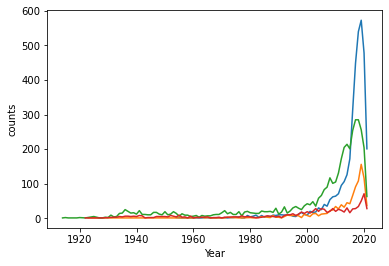

In [19]:
sns.lineplot(x="Year",y="counts",data=netflix_movies_year_df)
sns.lineplot(x="Year",y="counts",data=hulu_movies_year_df)
sns.lineplot(x="Year",y="counts",data=prime_movies_year_df)
sns.lineplot(x="Year",y="counts",data=disney_movies_year_df)

# Score Cleaning

In [20]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac


In [21]:
streaming_movies_df['IMDb Cleaning'] = streaming_movies_df['IMDb'].fillna(0)
streaming_movies_df['IMDb Cleaning'] = streaming_movies_df['IMDb Cleaning'].apply(convert_to_float)
streaming_movies_df = streaming_movies_df[(streaming_movies_df['IMDb Cleaning'] > 0)]


streaming_movies_df['Rotten Tomatoes Cleaning'] = streaming_movies_df['Rotten Tomatoes'].fillna(0)
streaming_movies_df['Rotten Tomatoes Cleaning'] = streaming_movies_df['Rotten Tomatoes Cleaning'].apply(convert_to_float)
streaming_movies_df = streaming_movies_df[(streaming_movies_df['Rotten Tomatoes Cleaning'] > 0)]



<ipython-input-21-6361c77e7257>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streaming_movies_df['Rotten Tomatoes Cleaning'] = streaming_movies_df['Rotten Tomatoes'].fillna(0)
<ipython-input-21-6361c77e7257>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streaming_movies_df['Rotten Tomatoes Cleaning'] = streaming_movies_df['Rotten Tomatoes Cleaning'].apply(convert_to_float)


In [22]:
Netflix_Score = streaming_movies_df[(streaming_movies_df['Netflix'] > 0)]
Hulu_Score = streaming_movies_df[(streaming_movies_df['Hulu'] > 0)]
Disney_Score = streaming_movies_df[(streaming_movies_df['Disney+'] > 0)]
Prime_Score = streaming_movies_df[(streaming_movies_df['Prime Video'] > 0)]

In [23]:
Netflix_Score["IMDb Cleaning"].mean()
Hulu_Score["IMDb Cleaning"].mean()
IMDb_Score = {'Streaming Sites': ["Netflix", "Hulu", "Disney", "Prime Video"], 
              'IMDb Score': [Netflix_Score["IMDb Cleaning"].mean(), Hulu_Score["IMDb Cleaning"].mean(),
                       Disney_Score["IMDb Cleaning"].mean(), Prime_Score["IMDb Cleaning"].mean()]}
IMDb_Score_df = pd.DataFrame(data=IMDb_Score)
IMDb_Score_df

,Streaming Sites,IMDb Score
0,Netflix,0.626643
1,Hulu,0.620760
2,Disney,0.656734
3,Prime Video,0.596750


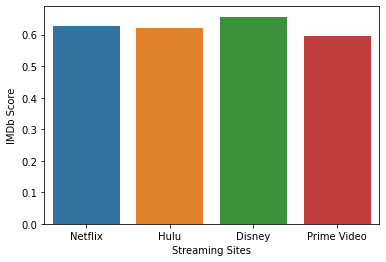

In [24]:
IMDb_Graph = sns.barplot(data = IMDb_Score_df, x = "Streaming Sites", y = "IMDb Score")
#IMDb_Score_df.info()

In [25]:
RT_Score = {'Streaming Sites': ["Netflix", "Hulu", "Disney", "Prime Video"], 
              'Rotten Tomatoes Score': [Netflix_Score["Rotten Tomatoes Cleaning"].mean(), Hulu_Score["Rotten Tomatoes Cleaning"].mean(),
                       Disney_Score["Rotten Tomatoes Cleaning"].mean(), Prime_Score["Rotten Tomatoes Cleaning"].mean()]}
RT_Score_df = pd.DataFrame(data=RT_Score)
RT_Score_df

,Streaming Sites,Rotten Tomatoes Score
0,Netflix,0.552671
1,Hulu,0.606660
2,Disney,0.592096
3,Prime Video,0.508939


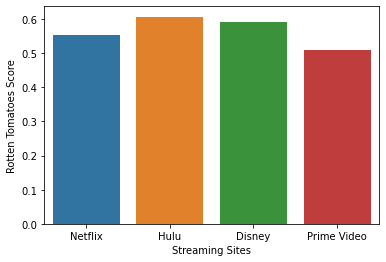

In [26]:
IMDb_Graph = sns.barplot(data = RT_Score_df, x = "Streaming Sites", y = "Rotten Tomatoes Score")
#IMDb_Score_df.info()

# Top/Bottom 10 in the UK

In [27]:
Top_10

,title,genres,Unnamed: 0,duration
323,Acrimony,"Drama, Romance, Thriller",664530.0,3.499393e+06
2706,Gruesome School Trip,"Adventure, Family, Fantasy, Horror",589025.0,3.174813e+06
2858,Hep Yek 2,"Comedy, Crime",718646.0,2.306399e+06
415,Aliens in the Attic,"Adventure, Comedy, Family, Fantasy, Sci-Fi",270046.0,2.152714e+06
4110,Marie Antoinette,"Biography, Drama, History, Romance",242879.5,2.068908e+06
2984,House of Games,"Crime, Thriller",486245.0,1.805897e+06
5141,Proprietors Kammath and Kammath,NOT AVAILABLE,469990.5,1.788196e+06
7481,The Three Stooges,"Comedy, Family",676467.0,1.433506e+06
3717,Late Life: The Chien-Ming Wang Story,"Documentary, Sport",670114.0,1.353309e+06
4317,Mobile Suit Zeta Gundam,NOT AVAILABLE,450566.0,1.284472e+06


In [28]:
UK_DF['genres'] = UK_DF['genres'].astype('str')

In [29]:
processed_docs = UK_DF["genres"]
processed_docs.head()

0                               Comedy, Drama, Romance
1                   Fantasy, Horror, Mystery, Thriller
2                                     Action, Thriller
3                                        Action, Drama
4    Animation, Action, Adventure, Comedy, Family, ...
Name: genres, dtype: object

In [30]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


In [31]:
processed_docs = processed_docs.map(preprocess)
processed_docs.head()

dictionary = gensim.corpora.Dictionary(processed_docs)

In [32]:
for x in range(0, 26):
    print(x,":",dictionary[x])

0 : comedy
1 : drama
2 : romance
3 : fantasy
4 : horror
5 : mystery
6 : thriller
7 : action
8 : adventure
9 : animation
10 : family
11 : history
12 : musical
13 : biography
14 : sport
15 : documentary
16 : crime
17 : music
18 : available
19 : western
20 : news
21 : short
22 : film
23 : noir
24 : reality
25 : talk


In [33]:
streaming_genre_df = streaming_movies_df["Genres"].astype(str)
streaming_genre_df = streaming_genre_df.map(preprocess)
streaming_dictionary_genre_df = gensim.corpora.Dictionary(streaming_genre_df)

In [34]:
for x in range(0, 26):
    print(x,":",streaming_dictionary_genre_df[x])

0 : biography
1 : crime
2 : drama
3 : action
4 : sport
5 : documentary
6 : musical
7 : history
8 : romance
9 : comedy
10 : adventure
11 : mystery
12 : western
13 : thriller
14 : music
15 : animation
16 : fantasy
17 : horror
18 : family
19 : short
20 : talk
21 : reality
22 : news
23 : game
24 : film
25 : noir


# Getting Top Genre/Director/Actor (All Streaming Websites)

In [35]:
def cleaning (genre):
    return genre.replace(',', ' ')

def biography (genre):
    if genre.find("Biography") != -1:
        return 1
    else:
        return 0
def crime (genre):
    if genre.find("Crime") != -1:
        return 1
    else:
        return 0
def action (genre):
    if genre.find("Action") != -1:
        return 1
    else:
        return 0
def sport (genre):
    if genre.find("sport") != -1:
        return 1
    else:
        return 0
def documentary (genre):
    if genre.find("documentary") != -1:
        return 1
    else:
        return 0
def musical (genre):
    if genre.find("musical") != -1:
        return 1
    else:
        return 0
def history (genre):
    if genre.find("history") != -1:
        return 1
    else:
        return 0
def romance (genre):
    if genre.find("romance") != -1:
        return 1
    else:
        return 0
def comedy (genre):
    if genre.find("comedy") != -1:
        return 1
    else:
        return 0
def adventure (genre):
    if genre.find("adventure") != -1:
        return 1
    else:
        return 0
def mystery (genre):
    if genre.find("mystery") != -1:
        return 1
    else:
        return 0
def western (genre):
    if genre.find("western") != -1:
        return 1
    else:
        return 0
def thriller (genre):
    if genre.find("thriller") != -1:
        return 1
    else:
        return 0
def music (genre):
    if genre.find("music") != -1:
        return 1
    else:
        return 0
def animation (genre):
    if genre.find("animation") != -1:
        return 1
    else:
        return 0
def fantasy (genre):
    if genre.find("fantasy") != -1:
        return 1
    else:
        return 0
def horror (genre):
    if genre.find("horror") != -1:
        return 1
    else:
        return 0
def family (genre):
    if genre.find("family") != -1:
        return 1
    else:
        return 0
def short (genre):
    if genre.find("short") != -1:
        return 1
    else:
        return 0
def family (genre):
    if genre.find("thriller") != -1:
        return 1
    else:
        return 0
def talk (genre):
    if genre.find("talk") != -1:
        return 1
    else:
        return 0
def reality (genre):
    if genre.find("reality") != -1:
        return 1
    else:
        return 0
def news (genre):
    if genre.find("news") != -1:
        return 1
    else:
        return 0
def game (genre):
    if genre.find("game") != -1:
        return 1
    else:
        return 0
def noir (genre):
    if genre.find("noir") != -1:
        return 1
    else:
        return 0
def film (genre):
    if genre.find("film") != -1:
        return 1
    else:
        return 0


In [36]:
streaming_movies_df["Genres Clean"] = streaming_movies_df["Genres"]

In [37]:
streaming_movies_df["Genres Clean"] = streaming_movies_df["Genres Clean"].astype(str)
streaming_movies_df["Genres Clean"] = streaming_movies_df["Genres Clean"].apply(cleaning)
streaming_movies_df["Biography"] = streaming_movies_df["Genres Clean"].apply(biography)
streaming_movies_df["Crime"] = streaming_movies_df["Genres Clean"].apply(crime)
streaming_movies_df["Action"] = streaming_movies_df["Genres Clean"].apply(action)
streaming_movies_df["Sport"] = streaming_movies_df["Genres Clean"].apply(sport)
streaming_movies_df["Documentary"] = streaming_movies_df["Genres Clean"].apply(documentary)
streaming_movies_df["Musical"] = streaming_movies_df["Genres Clean"].apply(musical)
streaming_movies_df["History"] = streaming_movies_df["Genres Clean"].apply(history)
streaming_movies_df["Romance"] = streaming_movies_df["Genres Clean"].apply(romance)
streaming_movies_df["Comedy"] = streaming_movies_df["Genres Clean"].apply(comedy)
streaming_movies_df["Adventure"] = streaming_movies_df["Genres Clean"].apply(adventure)
streaming_movies_df["Mystery"] = streaming_movies_df["Genres Clean"].apply(mystery)
streaming_movies_df["Western"] = streaming_movies_df["Genres Clean"].apply(western)
streaming_movies_df["Thriller"] = streaming_movies_df["Genres Clean"].apply(thriller)
streaming_movies_df["Music"] = streaming_movies_df["Genres Clean"].apply(music)
streaming_movies_df["Animation"] = streaming_movies_df["Genres Clean"].apply(animation)
streaming_movies_df["Fantasy"] = streaming_movies_df["Genres Clean"].apply(fantasy)
streaming_movies_df["Horror"] = streaming_movies_df["Genres Clean"].apply(horror)
streaming_movies_df["Family"] = streaming_movies_df["Genres Clean"].apply(family)
streaming_movies_df["Short"] = streaming_movies_df["Genres Clean"].apply(short)
streaming_movies_df["Talk"] = streaming_movies_df["Genres Clean"].apply(talk)
streaming_movies_df["Reality"] = streaming_movies_df["Genres Clean"].apply(reality)
streaming_movies_df["News"] = streaming_movies_df["Genres Clean"].apply(news)
streaming_movies_df["Game"] = streaming_movies_df["Genres Clean"].apply(game)
streaming_movies_df["Film"] = streaming_movies_df["Genres Clean"].apply(film)
streaming_movies_df["Noir"] = streaming_movies_df["Genres Clean"].apply(noir)

In [38]:
streaming_movies_genrelist_df = streaming_movies_df

In [39]:
#streaming_movies_genrelist_df = streaming_movies_genrelist_df.drop("ID", axis = 1)
#streaming_movies_genrelist_df = streaming_movies_genrelist_df.drop("Year", axis = 1)
#streaming_movies_genrelist_df = streaming_movies_genrelist_df.drop("Age", axis = 1)
#streaming_movies_genrelist_df = streaming_movies_genrelist_df.drop("Unnamed: 0", axis = 1)
streaming_movies_genrelist_df = streaming_movies_genrelist_df.drop("Country", axis = 1)


In [40]:
streaming_movies_genrelist_df

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,...,Fantasy,Horror,Family,Short,Talk,Reality,News,Game,Film,Noir
0,0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9497,9497,9498,Earth Live,2017,NaN,5.2/10,33/100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9498,9498,9499,World's Greatest Dogs,2015,NaN,6.0/10,33/100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9499,9499,9500,Wild Uganda,2018,7+,7.5/10,32/100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9500,9500,9501,Challenge Accepted! Disney Channel's Epic Holi...,2020,NaN,3.9/10,32/100,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
IMDb_Graph2 = px.bar(RT_Score_df, x = "Streaming Sites", y = "Rotten Tomatoes Score")

In [160]:
# -*- coding: utf-8 -*-

# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.
from jupyter_dash import JupyterDash
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd


external_stylesheets = [#'https://codepen.io/chriddyp/pen/bWLwgP.css'
    {
        'href': 'https://cdn.jsdelivr.net/npm/bootstrap@5.1.0/dist/css/bootstrap.min.css',
        'rel': 'stylesheet',
        'integrity': 'sha384-KyZXEAg3QhqLMpG8r+8fhAXLRk2vvoC2f3B09zVXn8CA5QIVfZOJ3BCsw2P0p/We',
        'crossorigin': 'anonymous',
       
    }
]


#external_stylesheets=[dbc.themes.DARKLY]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

sidebar_style = {
    "position":"fixed",
    #"position": "sticky",
    "top":0,
    "left":0,
    "bottom":0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
    "overflox":"scroll",
}

content_style = {
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
}

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

sidebar = html.Div([
        dbc.Nav(
            [
                dbc.NavLink("Home",href="#start",active ="exact"),
                dbc.NavLink("Streaming Services Trend", href="#Trend",active ="exact", external_link=True),
                dbc.NavLink("Effect of the Pandemic", href="#Pandemic",active ="exact", external_link=True),
                dbc.NavLink("Netflix at UK", href="#Net",active ="exact", external_link=True),
            ],
            vertical = True,
            pills=True
        )
    ],style = sidebar_style
)

content = html.Div([
    html.H1(children="How the Pandemic Affects the Streaming Services",id="start", style={'textAlign':'left','color':colors['text']}),
    html.Br(),
    html.P(children="With the pandemic going on, it changes the lives of many people and how the different industries work. It includes movie theaters having no choice but to halt..."),
    html.Br(),
    html.Br(),
    html.H3(children="STREAMING SERVICES TREND",id="Trend", style={'textAlign':'left','color':colors['text']}),
    html.Br(),
    html.P(children="To enable us to understand how the pandemic affects the streaming services, it would be best to check the different trends of these streaming services."),
    html.Div(className="break", children=[
        html.Br()
    ]),
    html.Div(className="scratch", children=[
        dcc.Tabs(id="tabs", value='tab-1', children=[
        dcc.Tab(label='Number of Shows Release', value='tab-1'),
        dcc.Tab(label='Average of Score of Each Streaming Service Get', value='tab-2'),
        dcc.Tab(label='Trending Genre Per Year', value='tab-3'),
        ])
    ]),
    html.Div(id='tabs-content'),
    html.Br(),
    html.Br(),
    html.Br(),
    
    html.H3(children="EFFECT OF THE PANDEMIC",id="Pandemic", style={'textAlign':'left','color':colors['text']}),
    html.Br(),
    html.P(children="The effect of the pandemic in different streaming services was shown below. the data will focus on Netflix alone. The number of subscribers of Netflix grows exponentially over the year..."),
    html.Div(className="scratch1", children=[
        dcc.Tabs(id="tabs1", value='tab-1', children=[
        dcc.Tab(label='Number of Subscribers vs Number of Shows Release 2019-2020', value='tab-1'),
        dcc.Tab(label='Revenue Gathered 2019-2020', value='tab-2'),
        ])
    ]),
    html.Div(id='tabs-content1'),
    
    html.Br(),
    html.Br(),
    
    html.H3(children="Netflix at UK",id="Net", style={'textAlign':'left','color':colors['text']})
    
],style=content_style)


app.layout = html.Div(className='container', children=[
    sidebar,content
])

@app.callback(
    Output('tabs-content', 'children'),
    Input('tabs', 'value')
)
def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
            html.H3('Filtering data 1'),
            html.H3(children="Insert table1 title",
            style={
            'textAlign': 'left',
            'color': colors['text']
            }
            ),
    
            html.Div(children='you can insert something here.'),

            dcc.Graph(
                id='IMDb-score',
                figure=IMDb_Graph2
            ),

            html.H5(children="insert paragraph/analysis here.")
        ])
    elif tab == 'tab-2':
        return html.Div([
            html.H3('Filtering data 2')
        ])
    elif tab == 'tab-3':
        return html.Div([
            html.H3('Filtering data 3')
        ])
    
@app.callback(
    Output('tabs-content1', 'children'),
    Input('tabs1', 'value')
)
def render_content(tab):
    if tab == 'tab-1':
        return html.Div([
            html.H3('Filtering data 1')
        ])
    elif tab == 'tab-2':
        return html.Div([
            html.H3('Filtering data 2')
        ])
    elif tab == 'tab-3':
        return html.Div([
            html.H3('Filtering data 3')
        ])
    
if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run